# https://www.dataquest.io/blog/introduction-to-ensembles/
### 1. below is how ensemble can help increase performance
### 2. directly scroll to the end and *check* the last section about how to use *mlens* to perform ensemble

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### Import data
# Always good to set a seed for reproducibility
SEED = 1111
np.random.seed(SEED)

df = pd.read_csv('./input.csv')

### Training and test set
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

def get_train_test(test_size=0.95):
    """Split Data into train and test sets."""
    y = 1 * (df.cand_pty_affiliation == "REP")
    X = df.drop(["cand_pty_affiliation"], axis=1)
    X = pd.get_dummies(X, sparse=True) # this one-hot the feature
    X.drop(X.columns[X.std() == 0], axis=1, inplace=True)
    return train_test_split(X, y, test_size=test_size, random_state=SEED)

xtrain, xtest, ytrain, ytest = get_train_test()

# A look at the data
print("\nExample data:")
df.head()


Example data:


,cand_pty_affiliation,cand_office_st,cand_office,cand_status,rpt_tp,transaction_tp,entity_tp,state,classification,cycle,transaction_amt
0,REP,US,P,C,Q3,15,IND,NY,Engineer,2016.0,500.0
1,DEM,US,P,C,M5,15E,IND,OR,Math-Stat,2016.0,50.0
2,DEM,US,P,C,M3,15,IND,TX,Scientist,2008.0,250.0
3,DEM,US,P,C,Q2,15E,IND,IN,Math-Stat,2016.0,250.0
4,REP,US,P,C,12G,15,IND,MA,Engineer,2016.0,184.0


In [2]:
print("\nFeatures")
xtest.head()


Features


,cycle,transaction_amt,cand_office_st_AK,cand_office_st_AL,cand_office_st_AR,cand_office_st_AZ,cand_office_st_CA,cand_office_st_CO,cand_office_st_CT,cand_office_st_DC,...,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,state_ZZ,classification_Engineer,classification_Math-Stat,classification_Scientist
3525,2012.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
62397,2016.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
60187,2016.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
54189,2008.0,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
22029,2016.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


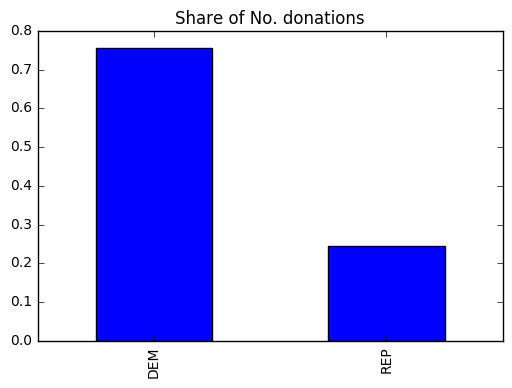

In [3]:
df.cand_pty_affiliation.value_counts(normalize=True).plot(
    kind="bar", title="Share of No. donations")
plt.show()

# Understanding ensembles by combining decision trees
We'll use the below helper function to visualize our decision rules:

# install graphviz and pydotplus
1. downloading from http://www.graphviz.org/download/
2. unzip the file, add path to windows path variables
3. then install pydot by pip install pydotplus followed by conda install pydot ; conda install pydotplus

In [4]:
import pydotplus  # you can install pydotplus with: pip install pydotplus 
from IPython.display import Image
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

def print_graph(clf, feature_names):
    """Print decision tree."""
    graph = export_graphviz(
        clf,
        label="root",
        proportion=True,
        impurity=False, 
        out_file=None, 
        feature_names=feature_names,
        class_names={0: "D", 1: "R"},
        filled=True,
        rounded=True
    )
    graph = pydotplus.graph_from_dot_data(graph)  
    return Image(graph.create_png())

Let's fit a decision tree with a single node (decision rule) on our training data and see how it perform on the test set

Decision tree ROC-AUC score: 0.672


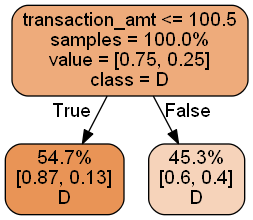

In [5]:
t1 = DecisionTreeClassifier(max_depth=1, random_state=SEED)
t1.fit(xtrain, ytrain)
p = t1.predict_proba(xtest)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t1, xtrain.columns)

# (see above) all prediction = D (demoncrate) as 75% of the training data is for D
Each of the two leaves register their share of training samples, the class distribution within their share, and the class label prediction. Our decision tree bases its prediction on whether the the size of the contribution is above 101.5: but it makes the same prediction regardless! This is not too surprising given that 75% of all donations are to Democrats. But it's not making use of the data we have. Let's use three levels of decision rules and see what we can get:

Decision tree ROC-AUC score: 0.750


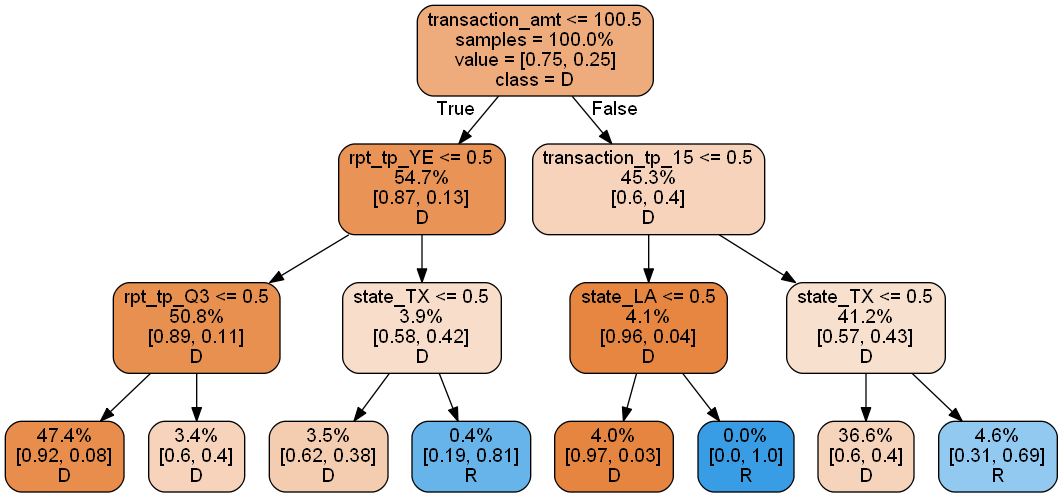

In [6]:
t2 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t2.fit(xtrain, ytrain)
p = t2.predict_proba(xtest)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t2, xtrain.columns)

# See Above 5% got be predicted to R (repulic)
This model is not much better than the simple decision tree: a measly **5%** = **0.4% + 4.6%** of all donations are predicted to go to Republicans–far short of the 25% we would expect. A closer look tells us that the decision tree uses some dubious splitting rules. 
## how to tell if the model has been overfit
A whopping 47.3% of all observations end up in the left-most leaf, while another 35.9% end up in the leaf second to the right. The vast majority of leaves are therefore irrelevant. ** *Making the model deeper just causes it to overfit.* **
### how to increase the *width* of decision tree? (compare below and above)
Fixing depth, a decision tree can be made more complex by increasing "width", that is, creating several decision trees and combining them. In other words, an ensemble of decision trees. To see why such a model would help, **consider how we may force a decision tree to investigate other patterns than those in the above tree. The simplest solution is to remove features that appear early in the tree.** Suppose for instance that we remove the transaction amount feature (transaction_amt), **the root of the tree**. Our new decision tree would look like this:

Decision tree ROC-AUC score: 0.738


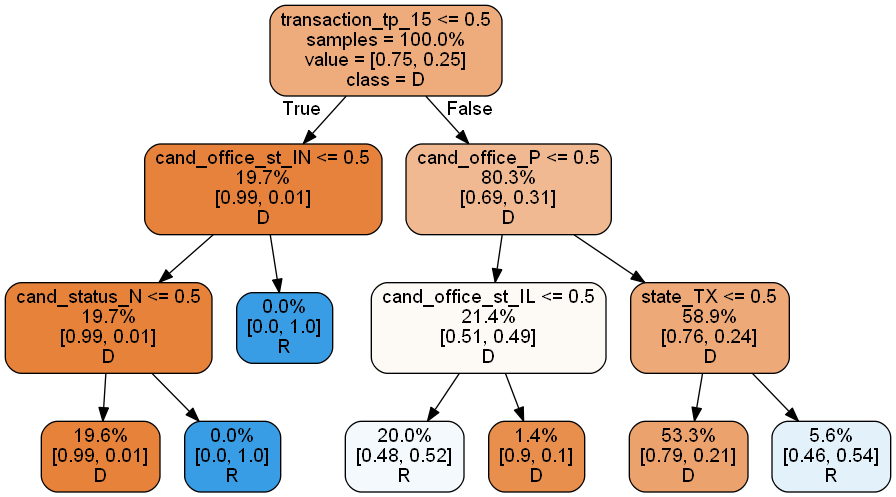

In [7]:
drop = ["transaction_amt"] # drop the root of previous decision tree

xtrain_slim = xtrain.drop(drop, 1)
xtest_slim = xtest.drop(drop, 1)

t3 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t3.fit(xtrain_slim, ytrain)
p = t3.predict_proba(xtest_slim)[:, 1]


print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t3, xtrain_slim.columns)

# See above, after removing trans_amt (root of previous tree)
The ROC-AUC score is similar, but the share of Republican donation increased to **7.3%**. Still too low, but higher than before. Importantly, in contrast to the first tree, where most of the rules related to the transaction itself, this tree is more focused on the residency of the candidate. We now have two models that by themselves have similar predictive power, but operate on different rules. Because of this, they are likely to make different prediction errors, which we can average out with an ensemble.

# A forest is an ensemble of trees, only un-correlated classifier shall be ensembled together
Returning to our prediction problem, let's see if we can build an ensemble out of our two decision trees. We first check error correlation: **highly correlated errors makes for poor ensembles**

In [8]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]
print("the correlation between tree2 and tree3: ")
pd.DataFrame({"full_data": p1,
              "reduced_data": p2}).corr()

the correlation between tree2 and tree3: 


,full_data,reduced_data
full_data,1.000000,0.549612
reduced_data,0.549612,1.000000


# let's see the ** simpleset ** ensemble method: average

In [9]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]
p = np.mean([p1, p2], axis=0)
print("will average ensemble help increase ROC?")
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

will average ensemble help increase ROC?
Average of decision tree ROC-AUC score: 0.793


### based on above results: Indeed, the ensemble procedure leads to an increased score. 
But maybe if we had more diverse trees, we could get an even greater gain. 
**How should we choose which features to exclude when designing the decision trees?**

## how to choose features to form un-correlated trees? : boost-trap = bagging = random forest
A fast approach that works well in practice is to randomly select a subset of features, fit one decision tree on each draw and average their predictions. *This process is known as **bootstrapped averaging** (often abbreviated **bagging**)*, and when applied to decision trees, the resultant model is a **Random Forest**. Let's see what a random forest can do for us. We use the Scikit-learn implementation and build an ensemble of 10 decision trees, each fitted on a subset of 3 features.

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=10,
    max_features=3,
    random_state=SEED
)

rf.fit(xtrain, ytrain)
p = rf.predict_proba(xtest)[:, 1]
print("let's checkout result of random forest")
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

let's checkout result of random forest
Average of decision tree ROC-AUC score: 0.848


## see above: The Random Forest yields a significant improvement upon our previous models. 

### Ensembles as averaged predictions
Our foray into ensembles so far has shown us two important aspects of ensembles:
1. The **less correlation** in prediction errors, the better
2. The **more models**, the better

In [11]:
# A host of Scikit-learn models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline

def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=SEED)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)

    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }

    return models

def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P

def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n") 

In [12]:
models = get_models()
P = train_predict(models)
score_models(P, ytest)

Fitting models.
logistic... done
naive bayes... done
svm... done
random forest... done
gbm... done
mlp-nn... done
knn... done
Done.

Scoring models.
logistic                  : 0.857
naive bayes               : 0.800
svm                       : 0.846
random forest             : 0.848
gbm                       : 0.877
mlp-nn                    : 0.839
knn                       : 0.784
Done.



#### below: You need ML-Ensemble for this figure: you can install it with: pip install mlens


[MLENS] backend: threading


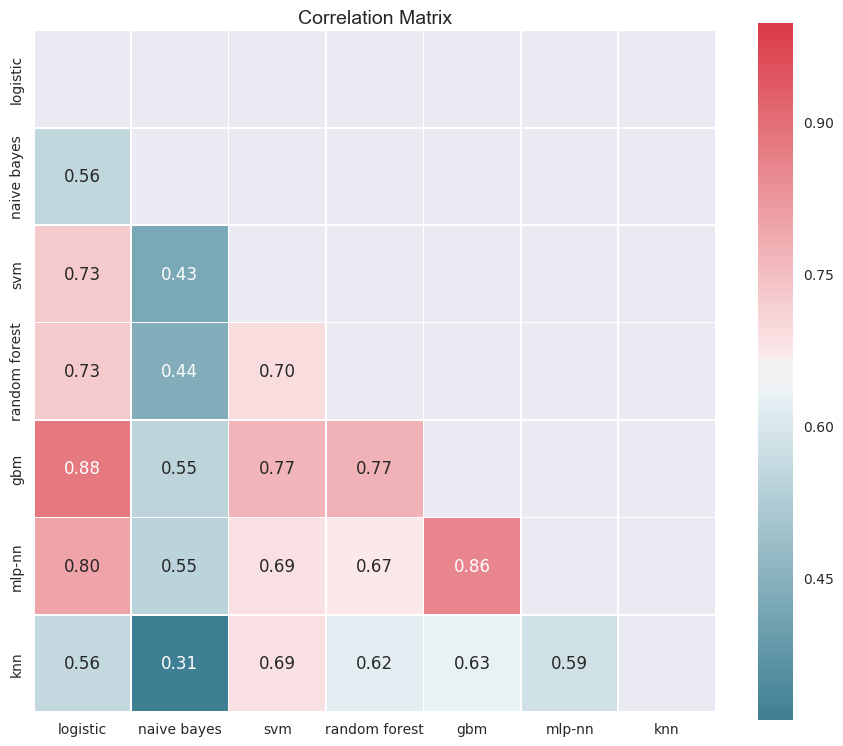

In [13]:
from mlens.visualization import corrmat

corrmat(P.corr(), inflate=False)
plt.show()

#### Errors are significantly correlated, which is to be expected for models that perform well, since it's typically the outliers that are hard to get right. 
Yet most correlations are in the 50-80% span, so there is decent room for improvement. 
### In fact, if we look at error correlations on a class prediction basis things look a bit more promising

Ensemble ROC-AUC score: 0.885


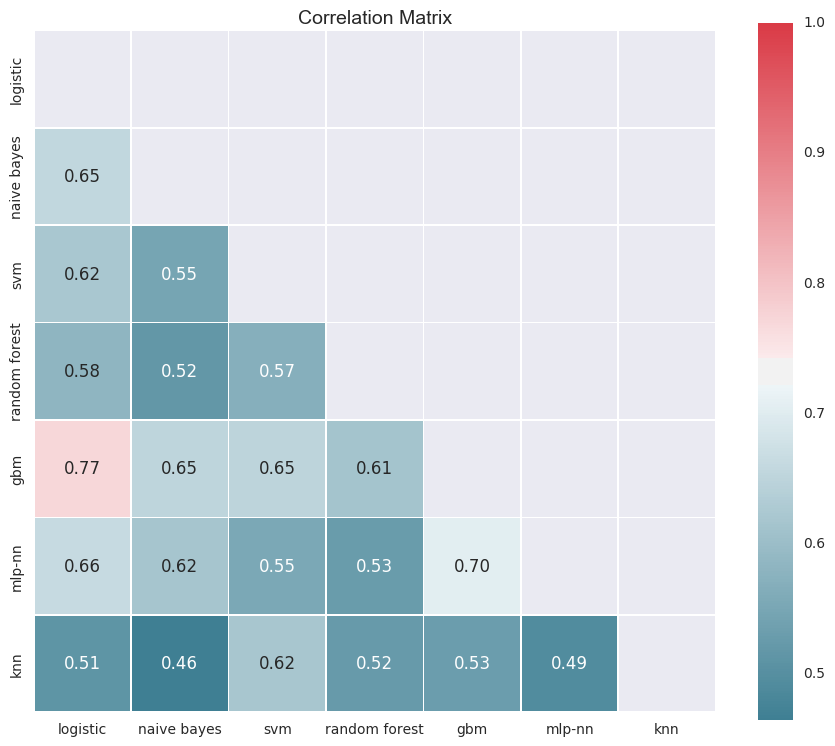

In [15]:
print("Ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.mean(axis=1)))

corrmat(P.apply(lambda pred: 1*(pred >= 0.5) - ytest.values).corr(), inflate=False)
plt.show()

Another way to understand what is going on in an ensemble when the task is classification, is to inspect the Receiver Operator Curve (ROC). This curve shows us how an estimator trades off precision and recall. Typically, different base learners make different trade offs: some have higher precision by sacrificing recall, and other have higher recall by sacrificing precision.

A non-linear meta learner, on the other hand, is able to, for each training point, adjust which models it relies on. This means that it can significantly reduce necessary sacrifices and retain high precision while increasing recall (or vice versa). In the figure below, the ensemble is making a much smaller sacrifice in precision to increase recall (the ROC is further in the "northeast" corner).

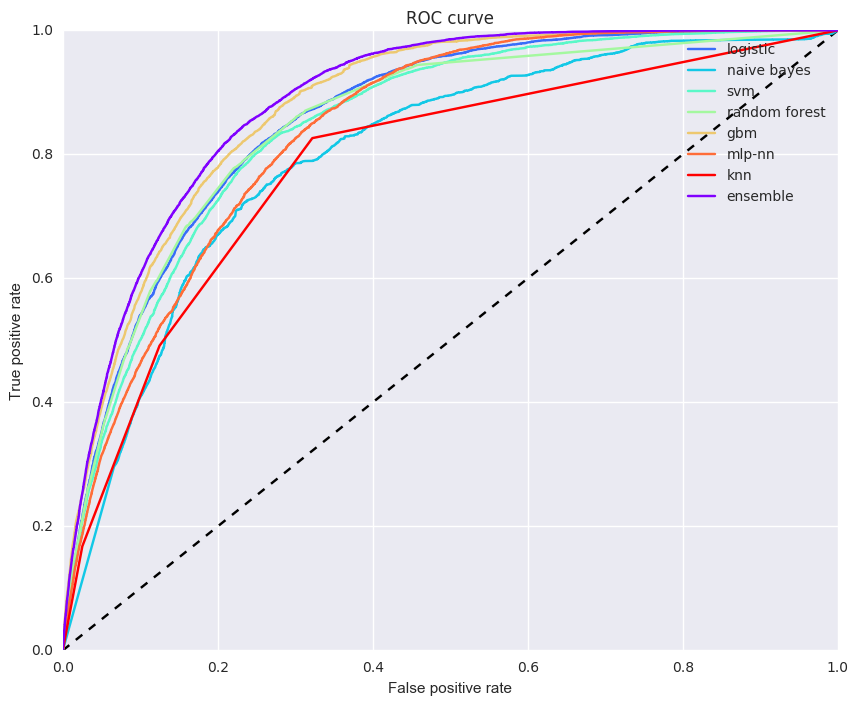

In [16]:
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    
    cm = [plt.cm.rainbow(i)
      for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(ytest, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

    fpr, tpr, _ = roc_curve(ytest, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])
        
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False)
    plt.show()

plot_roc_curve(ytest, P.values, P.mean(axis=1), list(P.columns), "ensemble")

### find bad apple
But wouldn't you expect more of a boost given the variation in prediction errors? Well, one thing is a bit nagging. Some of the models perform considerably worse than others, yet their influence is just large as better performing models. This can be quite devastating with unbalanced data sets: recall that with soft voting, if a model makes an extreme prediction (i.e close to 0 or 1), that prediction has a strong pull on the prediction average.

An important factor for us is whether models are able to capture the full share of Republican denotations. A simple check shows that all models underrepresent Republican donations, but some are considerably worse than others.

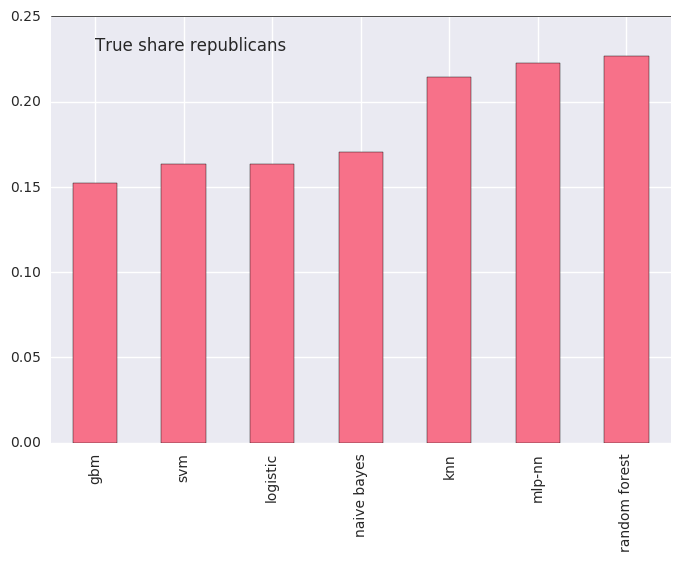

In [17]:
p = P.apply(lambda x: 1*(x >= 0.5).value_counts(normalize=True))
p.index = ["DEM", "REP"]
p.loc["REP", :].sort_values().plot(kind="bar")
plt.axhline(0.25, color="k", linewidth=0.5)
plt.text(0., 0.23, "True share republicans")
plt.show()

#### objective: choose better models, optimize the weight each predictor
# Implementing an ensemble
To build this type of ensemble, we need three things:

### 1. a library of base learners that generate predictions
### 2. a meta learner that learns how to best combine these predictions
### 3. a method for splitting the training data between the base learners and the meta learner.

Base learners are the ingoing models that take the original input and generate a set of predictions. If we have an original data set ordered as a matrix X of shape (n_samples, n_features), the library of base learners output a new prediction matrix P_base of size (n_samples, n_base_learners), **where each column represent the predictions made by one of the base learners**. The meta learner is trained on P_base.

In [19]:
# Step 1: define a library of base learners
base_learners = get_models()

# Step 2: define a meta learner
meta_learner = GradientBoostingClassifier(
    n_estimators=1000,
    loss="exponential",
    max_features=4,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.005, 
    random_state=SEED
)

# Step 3: define a procedure for generating train and test sets
xtrain_base, xpred_base, ytrain_base, ypred_base = train_test_split(
    xtrain, ytrain, test_size=0.5, random_state=SEED)

#Step 4: train the base learners on a training set
def train_base_learners(base_learners, inp, out, verbose=True):
    """Train all base learners in the library."""
    if verbose: print("Fitting models.")
    for i, (name, m) in enumerate(base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        m.fit(inp, out)
        if verbose: print("done")

# train base learners
train_base_learners(base_learners, xtrain_base, ytrain_base)

Fitting models.
logistic... done
naive bayes... done
svm... done
random forest... done
gbm... done
mlp-nn... done
knn... done


In [20]:
# Step 5: generate base learner predictions
def predict_base_learners(pred_base_learners, inp, verbose=True):
    """Generate a prediction matrix."""
    P = np.zeros((inp.shape[0], len(pred_base_learners)))

    if verbose: print("Generating base learner predictions.")
    for i, (name, m) in enumerate(pred_base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        p = m.predict_proba(inp)
        # With two classes, need only predictions for one class
        P[:, i] = p[:, 1]
        if verbose: print("done")

    return P
P_base = predict_base_learners(base_learners, xpred_base)
# Step 6: Train the meta learner using (P_base, ypred_base) where P_base is from 
meta_learner.fit(P_base, ypred_base)
def ensemble_predict(base_learners, meta_learner, inp, verbose=True):
    """Generate predictions from the ensemble."""
    P_pred = predict_base_learners(base_learners, inp, verbose=verbose)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]
P_pred, p = ensemble_predict(base_learners, meta_learner, xtest)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Generating base learner predictions.
logistic... done
naive bayes... done
svm... done
random forest... done
gbm... done
mlp-nn... done
knn... done
Generating base learner predictions.
logistic... done
naive bayes... done
svm... done
random forest... done
gbm... done
mlp-nn... done
knn... done

Ensemble ROC-AUC score: 0.887


# Training with cross-validation
Fitting an ensemble with cross-validation is often referred to as **stacking**, while the ensemble itself is known as the **Super Learner**

In [21]:
from sklearn.base import clone

def stacking(base_learners, meta_learner, X, y, generator):
    """Simple training routine for stacking."""

    # Train final base learners for test time
    print("Fitting final base learners...", end="")
    train_base_learners(base_learners, X, y, verbose=False)
    print("done")

    # Generate predictions for training meta learners
    # Outer loop:
    print("Generating cross-validated predictions...")
    cv_preds, cv_y = [], []
    for i, (train_idx, test_idx) in enumerate(generator.split(X)):

        fold_xtrain, fold_ytrain = X[train_idx, :], y[train_idx]
        fold_xtest, fold_ytest = X[test_idx, :], y[test_idx]

        # Inner loop: step 4 and 5
        fold_base_learners = {name: clone(model)
                              for name, model in base_learners.items()}
        train_base_learners(
            fold_base_learners, fold_xtrain, fold_ytrain, verbose=False)

        fold_P_base = predict_base_learners(
            fold_base_learners, fold_xtest, verbose=False)

        cv_preds.append(fold_P_base)
        cv_y.append(fold_ytest)
        print("Fold %i done" % (i + 1))

    print("CV-predictions done")
    
    # Be careful to get rows in the right order
    cv_preds = np.vstack(cv_preds)
    cv_y = np.hstack(cv_y)

    # Train meta learner
    print("Fitting meta learner...", end="")
    meta_learner.fit(cv_preds, cv_y)
    print("done")

    return base_learners, meta_learner

In [22]:
from sklearn.model_selection import KFold

# Train with stacking
cv_base_learners, cv_meta_learner = stacking(
    get_models(), clone(meta_learner), xtrain.values, ytrain.values, KFold(2))

P_pred, p = ensemble_predict(cv_base_learners, cv_meta_learner, xtest, verbose=False)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Fitting final base learners...done
Generating cross-validated predictions...
Fold 1 done
Fold 2 done
CV-predictions done
Fitting meta learner...done

Ensemble ROC-AUC score: 0.884


# how to use *mlens* to ensemble your models: use a unit-tested package and focus on building your machine learning pipeline. 
 1. settled on a ensemble package, building ensembles becomes really easy: 
 2. specify the base learners, the meta learner, and a method for training the ensemble.
### use ML-Ensemble and build our previous generalized ensemble, 10-fold cross-validation:

In [24]:
from mlens.ensemble import SuperLearner

# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=10,
    random_state=SEED,
    verbose=2,
    backend="multiprocessing"
)

# Add the base learners and the meta learner
sl.add(list(base_learners.values()), proba=True) ### base_learners get from get_model
sl.add_meta(meta_learner, proba=True) ### meta_learner defined by: GDB , see previous section

# Train the ensemble
sl.fit(xtrain, ytrain)

# Predict the test set
p_sl = sl.predict_proba(xtest)

print("\nSuper Learner ROC-AUC score: %.3f" % roc_auc_score(ytest, p_sl[:, 1]))


Fitting 2 layers
Processing layer-1             done | 00:02:48
Processing layer-2             done | 00:00:03
Fit complete                        | 00:02:55

Predicting 2 layers
Processing layer-1             done | 00:01:01
Processing layer-2             done | 00:00:02
Predict complete                    | 00:01:04

Super Learner ROC-AUC score: 0.890


# Inspecting the ROC-curve of the super learner against the simple average ensemble reveals how leveraging the full data enables the super learner to sacrifice less recall for a given level of precision

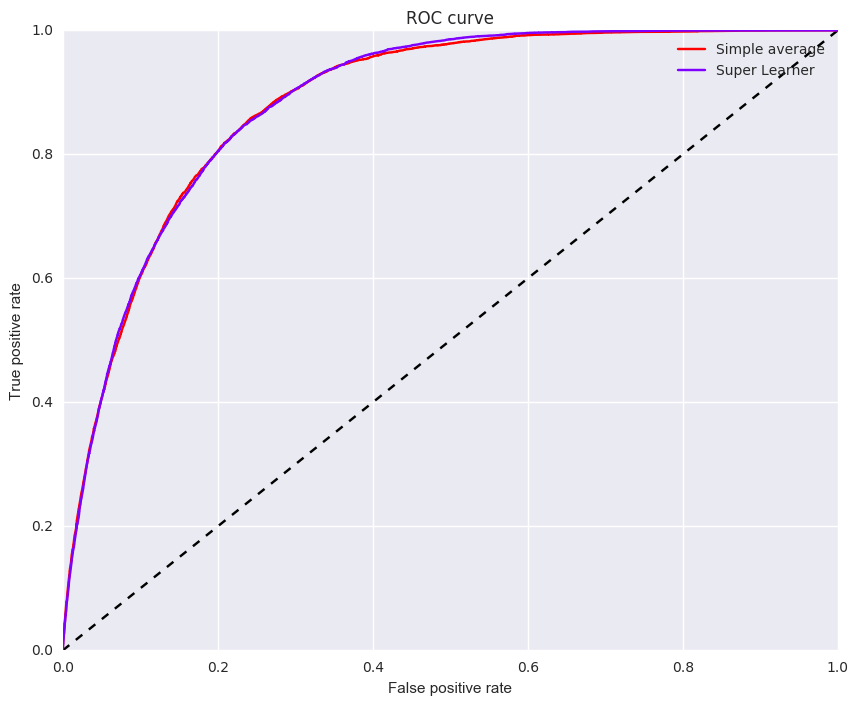

In [25]:
plot_roc_curve(ytest, p.reshape(-1, 1), P.mean(axis=1), ["Simple average"], "Super Learner")